# Introduction

The following notebook is for training double Q-learning with epsilon decay action select strategy agent on the task environment.

In [1]:
#Library imports

import gym
from gym import error, spaces, utils
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from collections import namedtuple, deque
from tqdm import tqdm, trange

In [2]:
#Import environment class
from blocks import EnvClass

In [3]:
#Function to play the given environment based on the given policy, without any randomness
def playEnv(env,policy):
    
    env.reset()
    s = env.present_state
    done = False
    a = int(policy[s][0])

    cur_reward = 0

    while not done:
        out = env.step(a)
        (s_prime,t),r,done,_ = out
        cur_reward += r
        a = int(policy[int(s_prime)][int(r)])
        
    return cur_reward

In [4]:
#Function to decay parameter from finalValue -> initialValue starting from startStep step and upto maxSteps using
#the decayType characteristic

def decayParameter(initialValue, finalValue, startStep, maxSteps, decayType):
    arr = [initialValue]
    para = initialValue
    step = 0
    
    if(decayType == 'linear'):
        rate = (initialValue-finalValue)/(maxSteps-startStep)
    else:
        rate = np.power(finalValue/initialValue, 1/(maxSteps-startStep))
    
    while(step < maxSteps):
        step += 1
        
        if(step>startStep):
            if(decayType=='linear'):
                para -= rate
            else:
                para *= rate
        arr.append(para)
        
    return(arr)

In [5]:
#Returns the greedy policy from the given state-action value function
def GreedyPolicy(Q):
    
    pi = np.zeros((Q.shape[0],Q.shape[1]))
    
    for s in range(Q.shape[0]):
        
        for r in range(Q.shape[1]):
            
            q = Q[s][r]

            #simple_argmax

            a = np.argmax(q)

            #a = np.random.choice(np.where(q == q.max())[0])

            pi[s][r] = int(a)
        
    return pi

In [6]:
#Function to train the double Q-learning agent
#takes as input various hyperparameters like gamma, no of episodes to train for as well as the 
#parameters for decaying alpha and epsilon parameters
#Env to train the agent on also has to be given as input

def double_q_learning(env, gamma, alpha, epsilon, noEpisodes):
    curr_q = np.zeros((9,201,8))
    curr_q_1 = np.zeros((9,201,8))
    curr_q_2 = np.zeros((9,201,8))
    
    total_rewards = []
    greedy_reward = []

    al,e = alpha[3], epsilon[3]
    
    alpha = decayParameter(*alpha)
    epsilon = decayParameter(*epsilon)
    
    def actionSelect(curr_state, curr_r, curr_q, eps):     #Epsilon Greedy Action Select
        if(np.random.uniform(0,1) < eps):
            action = np.random.choice(np.arange(8))
        else:
            if(np.all(curr_q[curr_state][curr_r] == np.zeros(8))):
                action = np.random.choice(np.arange(8))
            else:
                action = np.argmax(curr_q[curr_state][curr_r])
        
        return(action)
    
    for i in trange(noEpisodes):
        env.reset()
        curr_state = env.present_state
        curr_r = 0
        done = False
        
        total_r = 0
        
        while(not done):
#             print(epsilon[int(min(i, e-1))])
            a = actionSelect(curr_state, curr_r, curr_q, epsilon[int(min(i, e-1))])

            (s_new, r, done, _) = env.step(a)
            
            total_r += r
            
            if(np.random.uniform(0,1) <= 0.5):
            
                td_target = r
                a_opt = np.argmax(curr_q_1[s_new[0], int(r)])
                if(not done):  
                    td_target += gamma*curr_q_2[int(s_new[0])][int(r)][a_opt]
                
                td_error = td_target - curr_q_1[curr_state][curr_r][a]
            
                curr_q_1[curr_state][curr_r][a] += alpha[int(min(i, al-1))]*td_error
            
            else:
                td_target = r
                a_opt = np.argmax(curr_q_2[s_new[0], int(r)])
                if(not done):  
                    td_target += gamma*curr_q_1[int(s_new[0])][int(r)][a_opt]
                
                td_error = td_target - curr_q_2[curr_state][curr_r][a]
            
                curr_q_2[curr_state][curr_r][a] += alpha[int(min(i, al-1))]*td_error
                
            
            curr_state = s_new[0]
            curr_r = int(r)
            curr_q = (curr_q_1 + curr_q_2)/2
            
        total_rewards.append(total_r)
        greedy_reward.append(playEnv(env, GreedyPolicy(curr_q)))

    return curr_q, total_rewards, greedy_reward

# Training Agent and Experimentation

In [8]:
#Declaring hyperparameter values
gamma = 0.3
alpha = 0.05
epsilon = 1
noEpisodes = 10000

envs = EnvClass()
env = envs.getBlock(3)       # Training Agent and Experimentation

Q_s  = np.zeros((5, 9, 201, 8))
rewards = np.zeros((5, noEpisodes))
g_rewards = np.zeros((5, noEpisodes))

for i in range(5):
    np.random.seed(i)
    env.reset()

    Q, reward, greward = double_q_learning(env, gamma, (alpha, 0.01, 0, noEpisodes, 'exponential'), (epsilon, 0.01, 1000, (9*noEpisodes)//10, 'linear'), noEpisodes)

    Q_s[i] = Q
    rewards[i] = reward
    g_rewards[i] = greward

Q = np.mean(Q_s, axis=0)
p = GreedyPolicy(Q)
print(playEnv(env, p))

100%|█████████████████████████████████████| 10000/10000 [04:13<00:00, 39.38it/s]

23574


In [9]:
#Score of final greedy policy
Q = np.mean(Q_s, axis=0)
p = GreedyPolicy(Q)
print(playEnv(env, p))


#Uncomment to save rewards per episode, greedy_rewards per episode and final policy

# np.savez('./policies/double_q_learning_B3_policy.npz', p)
# np.savez('./policies/double_q_learning_B3_reward.npz', np.mean(rewards, axis=0))
# np.savez('./policies/double_q_learning_B3_greward.npz', np.mean(g_rewards, axis=0))


23574


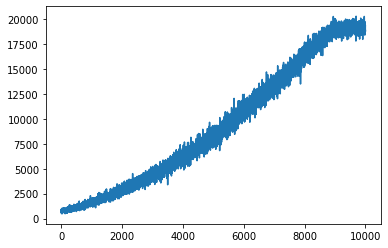

In [13]:
#Plot for reward per episode averaged over multiple seeds
plt.plot(np.mean(rewards, axis=0))
# plt.savefig('./policies/double_q_learning_gamma_04_B1.pdf')